In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [4]:
from tests.helpers import jaxley2neuron_by_group, import_neuron_morph, match_stim_loc
import numpy as np
import matplotlib.pyplot as plt
from jaxley.channels import HH
from jaxley.io.graph import swc_to_graph, from_graph
import jaxley as jx

__file__ = "../tests/"

def test_swc2graph_voltages():
    """Check if voltages of SWC recording match.

    To match the branch indices between NEURON and jaxley, we rely on comparing the
    length of the branches.

    It tests whether, on average over time and recordings, the voltage is off by less
    than 1.5 mV.
    """
    dirname = os.path.dirname(__file__)
    fname = os.path.join(dirname, "swc_files/morph.swc")
    
    nseg = 8

    i_delay = 2.0
    i_dur = 5.0
    i_amp = 0.25
    t_max = 20.0
    dt = 0.025

    ##################### NEURON ##################
    h, neuron_cell = import_neuron_morph(fname, nseg=nseg)

    ####################### jaxley ##################
    graph = swc_to_graph(fname)
    jx_cell = from_graph(graph, nseg=nseg, max_branch_len=2000, ignore_swc_trace_errors=False)
    jx_cell._update_nodes_with_xyz()
    jx_cell.insert(HH())

    branch_loc = 0.05
    neuron_inds, jaxley_inds = jaxley2neuron_by_group(jx_cell, h.allsec(), loc=branch_loc)
    trunk_inds, tuft_inds, basal_inds = [jaxley_inds[key] for key in ["trunk", "tuft", "basal"]]
    neuron_trunk_inds, neuron_tuft_inds, neuron_basal_inds = [neuron_inds[key] for key in ["trunk", "tuft", "basal"]]
    
    stim_loc = 0.1
    stim_idx = match_stim_loc(jx_cell, h.soma[0], loc=stim_loc)

    jx_cell.set("axial_resistivity", 1_000.0)
    jx_cell.set("v", -62.0)
    jx_cell.set("HH_m", 0.074901)
    jx_cell.set("HH_h", 0.4889)
    jx_cell.set("HH_n", 0.3644787)

    jx_cell.branch.comp(stim_idx).stimulate(
        jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
    )
    for i in trunk_inds + tuft_inds + basal_inds:
        jx_cell.branch(i).loc(branch_loc).record()

    voltages_jaxley = jx.integrate(jx_cell, delta_t=dt)

    ################### NEURON #################
    stim = h.IClamp(h.soma[0](stim_loc))
    stim.delay = i_delay
    stim.dur = i_dur
    stim.amp = i_amp

    counter = 0
    voltage_recs = {}

    for r in neuron_trunk_inds:
        for i, sec in enumerate(h.allsec()):
            if i == r:
                v = h.Vector()
                v.record(sec(branch_loc)._ref_v)
                voltage_recs[f"v{counter}"] = v
                counter += 1

    for r in neuron_tuft_inds:
        for i, sec in enumerate(h.allsec()):
            if i == r:
                v = h.Vector()
                v.record(sec(branch_loc)._ref_v)
                voltage_recs[f"v{counter}"] = v
                counter += 1

    for r in neuron_basal_inds:
        for i, sec in enumerate(h.allsec()):
            if i == r:
                v = h.Vector()
                v.record(sec(branch_loc)._ref_v)
                voltage_recs[f"v{counter}"] = v
                counter += 1

    for sec in h.allsec():
        sec.insert("hh")
        sec.Ra = 1_000.0

        sec.gnabar_hh = 0.120  # S/cm2
        sec.gkbar_hh = 0.036  # S/cm2
        sec.gl_hh = 0.0003  # S/cm2
        sec.ena = 50  # mV
        sec.ek = -77.0  # mV
        sec.el_hh = -54.3  # mV

    h.dt = dt
    tstop = t_max
    v_init = -62.0

    def initialize():
        h.finitialize(v_init)
        h.fcurrent()

    def integrate():
        while h.t < tstop:
            h.fadvance()

    initialize()
    integrate()
    voltages_neuron = np.asarray([voltage_recs[key] for key in voltage_recs])

    ####################### check ################
    errors = np.mean(np.abs(voltages_jaxley - voltages_neuron), axis=1)

    return errors, voltages_jaxley, voltages_neuron

In [5]:
mses, voltages_jaxley, voltages_neuron = test_swc2graph_voltages()

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.r

MSEs between networkX and NEURON voltages [1.04713083 0.73238157 0.78720334 1.05762205 0.99585735 1.11922611
 1.12190617 1.12657769 1.12535293 1.12256981 1.10160268 1.09620648
 1.10002585 1.06741559 0.90002977 1.11516644 1.13194185 1.14260492
 1.14133652 1.17697314 1.06901444 1.1187505  1.22594399 1.07062674
 1.25663968 1.22523276 1.23506127 1.21981076 1.22163891 1.2488945
 1.31928461 1.07650394 1.05729204 1.32271418 1.12422674 1.31578322
 1.12269393 1.02971737 1.10680595 1.1092448  0.84590106 0.85764662
 0.91513874 0.91375179 0.76595266 0.84695225 1.00529098 0.99369001
 1.02711285 1.0299318 ]


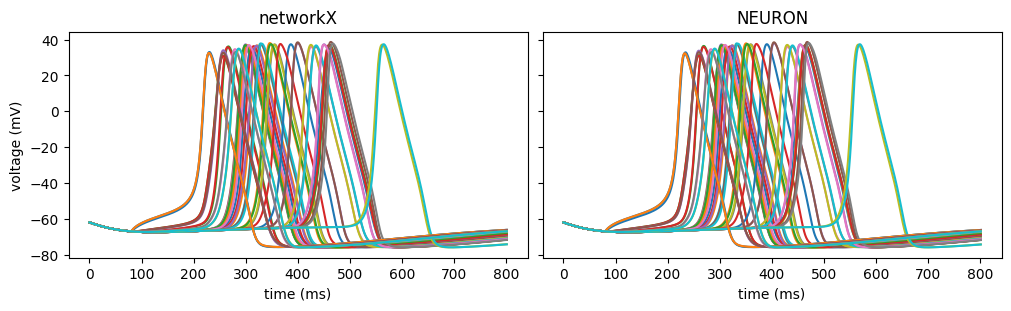

In [6]:
print("MSEs between networkX and NEURON voltages", mses)
# print("MSEs between jaxley_swc_reader and NEURON voltages", np.mean(np.abs(v_swc - v_swc_neuron), axis=1)) 

# plot the different voltages
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True, layout="constrained")
ax[0].plot(voltages_jaxley.T)
ax[1].plot(voltages_neuron.T)
ax[0].set_title("networkX")
ax[1].set_title("NEURON")
ax[0].set_ylabel("voltage (mV)")
ax[0].set_ylabel("voltage (mV)")
ax[1].set_xlabel("time (ms)")
ax[0].set_xlabel("time (ms)")

plt.show()